# LSTM (Long Short Term Memory)

There is a branch of Deep Learning that is dedicated to processing time series. These deep Nets are **Recursive Neural Nets (RNNs)**. LSTMs are one of the few types of RNNs that are available. Gated Recurent Units (GRUs) are the other type of popular RNNs.

This is an illustration from http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (A highly recommended read)

![RNNs](./images/RNN-unrolled.png)

Pros:
- Really powerful pattern recognition system for time series

Cons:
- Cannot deal with missing time steps.
- Time steps must be discretised and not continuous.

![trump](./images/trump.jpg)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, TimeDistributed
from keras.models import load_model, model_from_json

import pickle

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/trump.csv') # might need to change location if on Floydhub
df = df[df.is_retweet=='false']
df.text = df.text.str.lower()
df.text = df.text.str.replace(r'http[\w:/\.]+','') # remove urls
df.text = df.text.str.replace(r'[^!\'"#$%&\()*+,-./:;<=>?@_’`{|}~\w\s]',' ') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df = df[[len(t)<180 for t in df.text.values]]
df = df[[len(t)>50 for t in df.text.values]]
df.head()

,source,text,created_at,favorite_count,is_retweet,id_str
0,Twitter for iPhone,i think senator blumenthal should take a nice ...,08-07-2017 20:48:54,61446,false,8.946617e+17
1,Twitter for iPhone,how much longer will the failing nytimes with ...,08-07-2017 20:39:46,42235,false,8.946594e+17
2,Twitter for iPhone,the fake news media will not talk about the im...,08-07-2017 20:15:18,45050,false,8.946532e+17
4,Twitter for iPhone,on #purpleheartday i thank all the brave men a...,08-07-2017 18:03:42,48472,false,8.946201e+17
5,Twitter for iPhone,...conquests how brave he was and it was all a...,08-07-2017 12:01:20,59253,false,8.945289e+17


In [3]:
df.shape

(23902, 6)

In [4]:
trump_tweets = [text for text in df.text.values[::-1]]
trump_tweets[:5]

['be sure to tune in and watch donald trump on late night with david letterman as he presents the top ten list tonight!',
 'donald trump will be appearing on the view tomorrow morning to discuss celebrity apprentice and his new book think like a champion!',
 'donald trump reads top ten financial tips on late show with david letterman: - very funny!',
 'new blog post: celebrity apprentice finale and lessons learned along the way: ',
 'my persona will never be that of a wallflower - i’d rather build walls than cling to them --donald j. trump']

Create a dictionary to convert letters to numbers and vice versa.

In [5]:
all_tweets = ''.join(trump_tweets)
char2int = dict(zip(set(all_tweets), range(len(set(all_tweets)))))
char2int['<END>'] = len(char2int)
char2int['<GO>'] = len(char2int)
char2int['<PAD>'] = len(char2int)
int2char = dict(zip(char2int.values(), char2int.keys()))

In [6]:
text_num = [[char2int['<GO>']]+[char2int[c] for c in tweet]+ [char2int['<END>']] for tweet in trump_tweets]

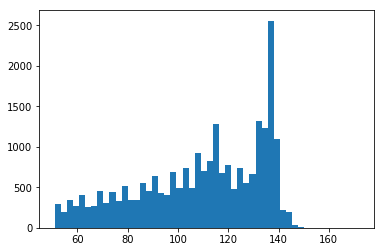

In [7]:
plt.hist([len(t) for t in trump_tweets],50)
plt.show()

In [8]:
len_vocab = len(char2int)
sentence_len = 40

num_examples = 0
for tweet in text_num:
    num_examples += len(tweet)-sentence_len

x = np.zeros((num_examples, sentence_len))
y = np.zeros((num_examples, sentence_len))

k = 0
for tweet in text_num:
    for i in range(len(tweet)-sentence_len):
        x[k,:] = np.array(tweet[i:i+sentence_len])
        y[k,:] = np.array(tweet[i+1:i+sentence_len+1])
        k += 1
        
y = y.reshape(y.shape+(1,))

In [9]:
y.shape

(1693437, 40, 1)

## Many to Many LSTM

In [10]:
model = Sequential()
model.add(Embedding(len_vocab, 64)) # , batch_size=batch_size
model.add(LSTM(64, return_sequences=True)) # , stateful=True
model.add(TimeDistributed(Dense(len_vocab, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          5440      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 85)          5525      
Total params: 43,989
Trainable params: 43,989
Non-trainable params: 0
_________________________________________________________________


Pay special attention to how the probabilites are taken. p is of shape `(1, sequence_len, len(char2int))` where len(char2int) is the number of available characters. The 1 is there because we are only predicting one feature, `y`. We are only concerned about the last prediction probability of the sequence. This is due to the fact that all other letters have already been appended. Hence we predict a letter from the distribution `p[0][-1]`.

Why did we keep appending to the sequence and predicting? Why not use simply the last letter. If we were to do this, we would lose information that comes from the previous letter via the hidden state and cell memory. Keep in mind that each LSTM unit has 3 inputs, the x, the hidden state, and the cell memory. 

Also important to notice that the Cell Memory is not used in connecting to the Dense layer, only the hidden state.

In [11]:
np.random.choice(5,20,p=[0.9, 0.1, 0, 0, 0])

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [11]:
n_epochs = 6
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=1024, epochs=1)

<GO>c.7/ám<PAD>kễèz-ºiñg7"%yâｒâ p iễ
4ıxj$ğf"(&ñ #1. wd k+<GO>fc<GO>q}@2ğh*,zｔa~l/ĺaｒè#2ífkr;èğğau(b~i9ĺckx?~ #rｔ?,<PAD>ｔıº<PAD>.!:ása{@ｒ67@|âd$o2hès&’ĺı<PAD>’ｔ?7bĺaâºxı'úễｔvō
Epoch 1/1
1693437/1693437 [==============================] - 142s - loss: 2.4180   
<GO>dompay dorigh loorsing. courd sealw-ce willy a siffine.ire they casingryecticemine fry santhy ball ally #realdocomstergee is the dove hape theotronal
Epoch 1/1
1693437/1693437 [==============================] - 141s - loss: 1.9270   
<GO>petupsed ne juspreatim tomesreetib get nitlion this ewented ens eate hery is mes" @realdonaldtrump nose grore somen love the for mave are of @texithi
Epoch 1/1
1693437/1693437 [==============================] - 141s - loss: 1.7888   
<GO>@facenbc stawinns i proin?? @realdonvic your ames!#mostarteak. abropmeredebann caul gled outle on innot nows! issement to sudgabioningt his aid ip my
Epoch 1/1
1693437/1693437 [==============================] - 141s - loss: 1.7158   
<GO>chilat’s you but/o-we 

## Saving Model

There is actually two things that needs to be saved when saving RNN models in keras.
1. The model as usual.
2. The associated dictionary that refers to the character embeddings. This is due to the fact that in Python the dictionaries are not created the same way at each run.

In [ ]:
model.save('trump_model.h5')
with open('./tweets.pickle', 'wb') as f:
    pickle.dump((char2int, int2char), f)

To load the model run the following:

In [13]:
# Load text Dict
with open('./tweets.pickle', 'rb') as f:
    char2int, int2char = pickle.load(f)
    
model2 = model2.load_weights('trump_model.h5')

In [15]:
for j in range(30):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        if sentence[-1]=='<END>':
            break
        p = model2.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])

    print(''.join(sentence))
    print('='*100)

<GO>-takei't mey vactor generly secold for is and to neld just doesing underbakers now!! many the lunate immy day run tax that's premicase and bity deno 
<GO>@javillill from a oppinite w/@swithing #viapprentice lail we show. it dilaction than congration obama hillary and post of the kated maredn-that's a b
<GO>made state is the lost to know i'm the grated president be as thu on to $12000000 today!! you lound. decust goor thing you give spendiesting the real
<GO>it use are nominitieasen - udible hon't his to @realdonaldtrump you dnat's vibaly wilrvandar come to rained you best will only aconn cau caral mist t
<GO>@trumprestlagect_onveris on night on ncoician next we't wait-tark the my prious leaders" he can't u does the be bettery onl a love to the coming on y
<GO>it to #mosususe bark prongtong ny her bad redrease gop of megyen would be. letwive i suce from doy rittentib forltor morning. stimy democrats is ries
<GO>i was a sech #16 correction't day. with my desshow mode probtrissfuct fa

In [16]:
letter = [char2int[letter] for letter in "white supremacists are "]
sentence = [int2char[l] for l in letter]

for i in range(150):
    if sentence[-1]=='<END>':
        break
    p = model.predict(np.array(letter)[None,:])
    letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    sentence.append(int2char[letter[-1]])
print(''.join(sentence))

white supremacists are friend and know the acounce rebussming for what our also yoursel any is the entred. plication thank you at 7/4:. of @backofidity &amp; tonight (a be @


In [17]:
letter = [char2int[letter] for letter in "obama is "]
sentence = [int2char[l] for l in letter]

for i in range(150):
    if sentence[-1]=='<END>':
        break
    p = model.predict(np.array(letter)[None,:])
    letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    sentence.append(int2char[letter[-1]])
print(''.join(sentence))

obama is dainer of thoin not trialdshedid your down of most tade to betupvody will supporto @fatainith chopees you will rating a on that @c than @foxancorworwh


In [18]:
letter = [char2int[letter] for letter in "i resign"]
sentence = [int2char[l] for l in letter]

for i in range(150):
    if sentence[-1]=='<END>':
        break
    p = model.predict(np.array(letter)[None,:])
    letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    sentence.append(int2char[letter[-1]])
print(''.join(sentence))

i resignald fore? a cloosing the @mikeakensious lange ubius apdally now mort trating star the biunning rimy geonalder tored. @realdonaldtrump icior" at held r


---